## Projekt uczenia maszynowego



* Przeanalizuj całokształt zadania
* Uzyskaj dane
* Przygotuj dane
* Odkryj i zwizualizuj dane w celu rozpoznania wzorców i dodatkowych informacji
* Przygotuj dane pod względem algorytmów uczenia maszynowego
* Wybierz i wyucz model
* Dostrój model
* Zaprezentuj rozwiązanie
* Uruchom, monitoruj i utrzymuj system

In [142]:
# biblioteki

import pandas as pd
import seaborn as sns
import numpy as np
from geopy import Nominatim
from geopy import GoogleV3
from tqdm.auto import tqdm
from time import sleep
import matplotlib.pyplot as plt
from math import sin, cos, atan2, sqrt, degrees, radians, pi
from geopy.distance import great_circle
from geopy.point import Point
from geopy import distance


In [221]:
# Import JSONa

df = pd.read_json('drive/My Drive/DataSets/Nieruchomosci3miasto/przygotowane_dane.json')

In [222]:
# Atrybuty

# Dwa geolocatory, które mają się uzupełniać
geolocator = Nominatim(user_agent='dts36@wp.pl') 
geolocatorGoogle = GoogleV3(api_key='') # Podmienić na swoje API

# Funkcje

def converterStr2Float(x):
  '''
  Jeśli wartości w kolumnie nie można zamienić na liczbę, to zastępowana jest ona NaN.
  Docelowo funkcja ma usuwać "Zapytaj o cenę" z kolumny CENA
  ''' 
  try:
    x = float(x)
  except ValueError:
    x = np.nan
  return x

def none2Nans(x):
  '''
  Zamiana '-1' na NaN.
  '''
  try:
    if float(x) == -1.0:
      return np.nan
    else:
      return x
  except ValueError:
    return x
  except  TypeError:
    return x


def okreslAdres(address):
  '''
  Funkcja określa adres i współrzędne nieruchomości na bazie adresów w kolumnie ADRES
  '''
  try:
    locData = geolocator.geocode(address)
    # Jeżeli Nominatim nie poradzi sobie z wyznaczeniem współrzędnych, korzystamy z Google
    if locData is None:
      return geolocatorGoogle.geocode(address)
    else:
      return locData
  except:
    # Czasami trzeba odpytać jeszcze raz, po krótkiej przerwie...
    try:
      sleep(1)
      locData = geolocator.geocode(address)
      if locData is None:
        return geolocatorGoogle.geocode(address)
      else:
        return locData
    except:
      # ...a czasami po dłuższej.
      try:
        sleep(5)
        locData = geolocator.geocode(address)
        if locData is None:
          return geolocatorGoogle.geocode(address)
        else:
          return locData
      except:
        return np.nan
      

def okreslRynek(rok, rynek):
  '''
  Funkcja aktualizuje kolumnę RYNEK o wartości 'wtórny' jeśli nieruchmość została zbudowana przed 2019 r.
  '''
  if float(rok) < 2019 and ~pd.isnull('rynek'):
    return 'wtórny'
  else:
    return rynek

def okreslMiasto(adres):
  '''
  Funkcja zwraca nazwę miasta bazując na danych adresowych nieruchomości
  '''
  try:
    if 'Gdańsk' in adres:
      return 'Gdańsk'
    elif 'Gdynia' in adres:
      return 'Gdynia'
    elif 'Sopot' in adres:
      return 'Sopot'
    else:
      return np.nan
  except:
    return np.nan
    

def korektaPieter(x):
  '''
  Funkcja ujednolica oznaczenia pięter: 'Parter' > 0, '5/7' > 5 
  '''
  if 'parter' in str(x).lower():
    return 0
  elif ' ' in str(x).lower():
    return int(str(x)[:str(x).index(' ')])
  elif pd.isnull(x):
    return x
  else:
    return int(x)

def setBCoordinate(adres):
  '''
  Funkcja wyciąga współrzędną B z wcześniej wyznaczonych adresów za pomocą funkcji okreslAdres
  '''
  try:
    return adres[1][0]
  except:
    return np.nan

def setLCoordinate(adres):
  '''
  Funkcja wyciąga współrzędną L z wcześniej wyznaczonych adresów za pomocą funkcji okreslAdres
  '''
  try:
    return adres[1][1]
  except:
    return np.nan

def obliczenieOdleglosciOdCentrum(B, L, city):
  '''
  Funkcja oblicza odległość pomiędzy centrum miasta a nieruchomością

  @param
  B - współrzędna B nieruchomości
  L - współrzędna L nieruchomości
  city - miasto, w ktorym znajduje się nieruchomość
  '''
  # Bc, Lc to Współrzędne centrum

  if city == 'Gdańsk':
    Bc = 54.3475
    Lc = 18.645278
    return float(distance.distance((B,L), (Bc, Lc)).km)

  elif city == "Gdynia":
    Bc = 54.519167
    Lc = 18.539444
    return float(distance.distance((B,L), (Bc, Lc)).km)

  elif city == 'Sopot':
    Bc = 54.441944
    Lc = 18.559722
    return float(distance.distance((B,L), (Bc, Lc)).km)

  else:
    print('Sth wrong')

def midpoint(a, b):
  '''
  Funkcja pomocnicza do Funkcji obliczającej odległość nieruchomości od linii (z założenia brzegowej)

  @param
  a - Point ze wspołrzędnymi punktu początkowego linii
  b - Point ze współrzędnymi punktu końcowego linii
  '''
  a_lat, a_lon = radians(a.latitude), radians(a.longitude)
  b_lat, b_lon = radians(b.latitude), radians(b.longitude)
  delta_lon = b_lon - a_lon
  B_x = cos(b_lat) * cos(delta_lon)
  B_y = cos(b_lat) * sin(delta_lon)
  mid_lat = atan2(
      sin(a_lat) + sin(b_lat),
      sqrt(((cos(a_lat) + B_x)**2 + B_y**2))
  )
  mid_lon = a_lon + atan2(B_y, cos(a_lat) + B_x)
  # Normalise
  mid_lon = (mid_lon + 3*pi) % (2*pi) - pi
  return Point(latitude=degrees(mid_lat), longitude=degrees(mid_lon))



def obliczanieOdleglosciOdMorza(B,L):
  '''
  Funkcja oblicza odległość nieruchomości od linii brzegowej (patrz szkic poniżej)
  Linię tworzą 3 punkty: a, b, c (2 linie)
  Funkcja oblicza najkrótsze odleglosci od linii i zwraca tę najmniejszą.

  @param
  B, L - współrzędne nieruchomości
  '''
  # Example:
  a = Point(latitude=54.635670, longitude=18.535485)
  b = Point(latitude=54.441223, longitude=18.581622)
  c = Point(latitude=54.357214 , longitude=18.828730)

  p = Point(latitude=B, longitude=L)

  d1 = great_circle(midpoint(a, b), p)
  d2 = great_circle(midpoint(b, c), p)
  
  return min([float(d1.km), float(d2.km)])


Szkic przyjętej linii brzegowej

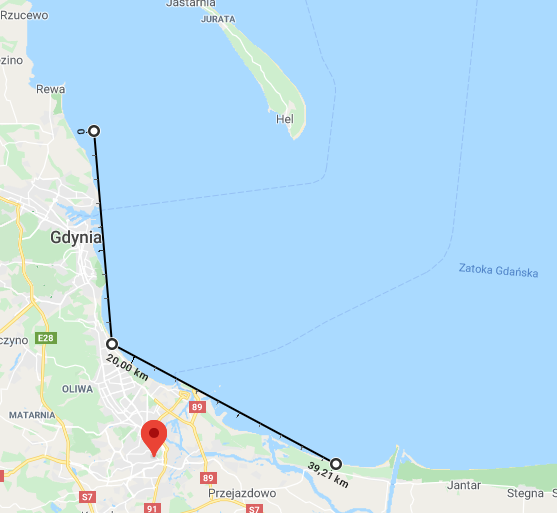

### Czyszczenie danych

In [223]:
# Wartości cen, których nie można przekonwertować na liczby (np. 'Zapytaj o cenę') zostają zamienione na NaN
df['cena'] = df['cena'].apply(lambda x: converterStr2Float(x))
# a następnie rekordy z NaN w kolumnie cena zostają usunięte
df = df.dropna(subset=['cena'])


In [224]:
# W każdej kolumnie -1 zostają zamienione na NaN

for column in list(df.columns):
  df[column] = df[column].apply(lambda x: none2Nans(x))

In [225]:
# Uzupełnienie kolumny 'rynek' o wartości 'wtórny', bazujące na roku budowy nieruchomości 
df['rynek_new'] = df.apply(lambda x: okreslRynek(x['rok_budowy'], x['rynek']), axis=1)

In [226]:
# Korektra oznaczenia pięter, na którym znajduje się mieszkanie
df['pietro_new'] = df['pietro']
df['pietro_new'] = df['pietro_new'].apply(lambda x: korektaPieter(x))

In [227]:
# Po pierwszej turze przetworzenia Datasetu sprawdzamy, które kolumny mają największą liczbę brakujących wartości
# 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22764 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   kuchnia                6999 non-null   object 
 1   rynek                  9396 non-null   object 
 2   balkon                 2631 non-null   object 
 3   liczba_pieter_budynku  22390 non-null  float64
 4   rok_budowy             22764 non-null  int64  
 5   miasto                 12250 non-null  object 
 6   liczba_pokoi           22712 non-null  float64
 7   wykonczenie            5590 non-null   object 
 8   ulica                  3923 non-null   object 
 9   pietro                 22587 non-null  object 
 10  rodzaj_zabudowy        9137 non-null   object 
 11  powierzchnia           22764 non-null  float64
 12  dzielnica              7001 non-null   object 
 13  forma-wlasnosci        1860 non-null   object 
 14  cena                   22764 non-null  float64
 15  adr

Funkcja uzupełniająca informacje o rynku odtworzyła blisko 11 tys. wartości (porównanie kolumny rynek i rynek_new)

Funkcja piętro prawidłowo przetworzyła wszystkie wartości 
(porównanie kolumny pietro i pietro_new)

Kolumna miasto powinna mieć tyle samo niezerowych wartości co kolumna adres, a więc jest do odtworzenia na bazie punktow adresowych)

Atrybuty, które nie posiadały min. 15 tys. wartości zostały odrzucone. 

In [229]:
# Lista kolumn, które uznałem za istotne z punktu widzenia trenowania modelu i które zawierały więcej niż 15 tys. atrybutów
bestCol = [ 'cena',
            'powierzchnia',
            'rynek_new',
            'rok_budowy',
            'liczba_pieter_budynku',
            'liczba_pokoi',
            'miasto',
            'pietro_new',
            'adres']

# Lista kolumn, w jakich nie może być wartości NaN. W porównaniu do zestawu kolumn powyżej, nie ma w niej miasta (bo te wartości zostaną odtworzone później)

noNanCol = [ 'cena',
            'powierzchnia',
            'rynek_new',
            'rok_budowy',
            'liczba_pieter_budynku',
            'liczba_pokoi',
            'pietro_new',
            'adres']


In [230]:
# Selekcja kolumn, które spełniały kryteria: liczba wartości atrybutów > 15 tys.
df = df[bestCol]

# Usunięcie rekordów, które zawierają wartości NaN
df = df.dropna(subset=noNanCol)


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20416 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cena                   20416 non-null  float64
 1   powierzchnia           20416 non-null  float64
 2   rynek_new              20416 non-null  object 
 3   rok_budowy             20416 non-null  int64  
 4   liczba_pieter_budynku  20416 non-null  float64
 5   liczba_pokoi           20416 non-null  float64
 6   miasto                 11454 non-null  object 
 7   pietro_new             20416 non-null  float64
 8   adres                  20416 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.6+ MB


In [ ]:
# Zamian adresów na adresy + współrzędne w formacie geopy
# !!! UWAGA - zajmuje to ok 3h !!!

tqdm.pandas()
df['adres_new'] = df['adres'].progress_apply(lambda x: okreslAdres(x))

In [ ]:
# Wyodrębnienie współrzędnych B i L z danych adresowych

df['B'] = df.apply(lambda x: setBCoordinate(x['adres_new']), axis=1)
df['L'] = df.apply(lambda x: setLCoordinate(x['adres_new']), axis=1)

In [60]:
# Aktualizacja wartości atrybutu MIASTO na bazie danych adresowych

df['miasto_new'] = df.apply(lambda x: okreslMiasto(x['adres_new']), axis= 1)

In [61]:
# Obliczenie ceny za 1 m2 

df['cena_za_metr'] = df.apply(lambda x: int(x['cena']/x['powierzchnia']), axis = 1)

In [114]:
# Usunięcie rekordów, które zawierały błędne adresy i przez to zostały wyznaczone złe współrzędne

df = df[df['B']>47]

In [ ]:
# Obliczenie odległości do centrum miasta

tqdm.pandas()
df['doCentrum'] = df.progress_apply(lambda x: obliczenieOdleglosciOdCentrum(x['B'], x['L'], x['miasto_new']), axis = 1)

In [154]:
# Obliczenie odległości do morza

df['doMorza'] = df.apply(lambda x: obliczanieOdleglosciOdMorza(x['B'], x['L']), axis = 1)

In [ ]:
# Nowa lista kolumn, które uznałem za istotne z punktu widzenia trenowania modelu

bestCol = [ 'cena',
            'powierzchnia',
            'cena_za_metr'
            'rynek_new',
            'rok_budowy',
            'liczba_pieter_budynku',
            'liczba_pokoi',
            'miasto_new',
            'pietro_new',
            'B',
            'L',
            'doMorza',
            'doCentrum']


In [ ]:
# Usunięcie zbędnych kolumn

df = df[bestCol]

In [62]:
# Usunięcie rekordów, które zawierają wartość NaN

df = df.dropna(subset=bestCol)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20303 entries, 0 to 20415
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             20303 non-null  int64  
 1   rynek_uzupelniony      20303 non-null  object 
 2   liczba_pieter_budynku  20303 non-null  float64
 3   rok_budowy             20303 non-null  int64  
 4   miasto                 11393 non-null  object 
 5   liczba_pokoi           20303 non-null  float64
 6   pietro_new             20303 non-null  float64
 7   powierzchnia           20303 non-null  float64
 8   cena                   20303 non-null  float64
 9   adres                  20303 non-null  object 
 10  adres_new              20303 non-null  object 
 11  B                      20303 non-null  float64
 12  L                      20303 non-null  float64
 13  miasto_new             20303 non-null  object 
 14  cena_za_metr           20303 non-null  int64  
dtypes:

In [ ]:
# !!! Każdy z atrybutów powinien mieć 20303 wartości !!!

df.info()

In [ ]:
# Zapis przetworzonego datasetu do pliku CSV

df.to_csv('drive/My Drive/DataSets/Nieruchomosci3miasto/3city_dataset_DT.csv', index=True)


### Analiza Danych - cdn...

In [232]:
df = pd.read_csv('drive/My Drive/DataSets/Nieruchomosci3miasto/3city_dataset_DT.csv')

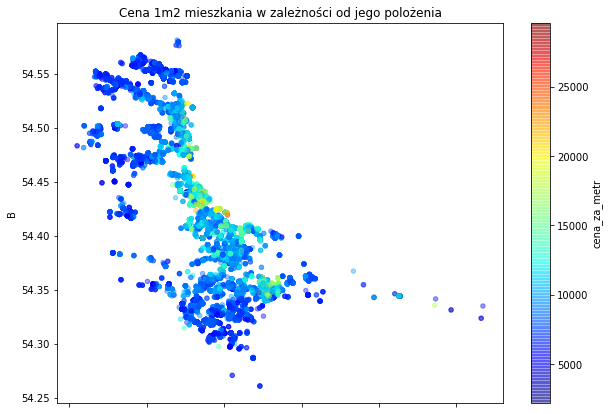

In [233]:
df.plot(kind='scatter', x='L', y='B', alpha=0.4, c='cena_za_metr', figsize=(10,7), cmap=plt.get_cmap('jet'),  title = 'Cena 1m2 mieszkania w zależności od jego polożenia')

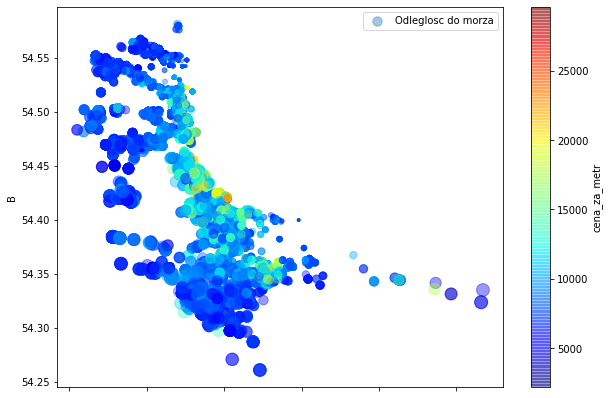

In [234]:
df.plot(kind='scatter', x='L', y='B', alpha=0.4, c='cena_za_metr', figsize=(10,7), cmap=plt.get_cmap('jet'), s=df['doMorza']*10, label = 'Odleglosc do morza')

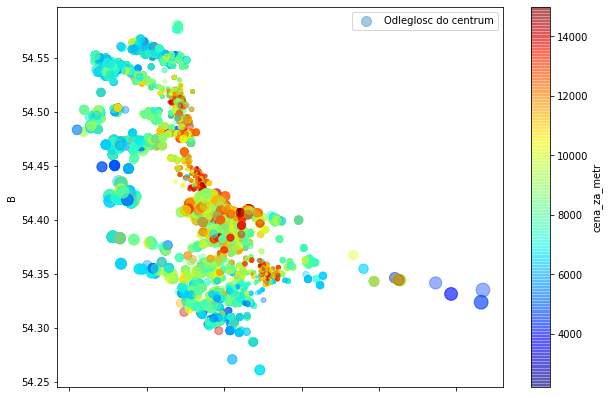

In [194]:
df.plot(kind='scatter', x='L', y='B', alpha=0.4, c='cena_za_metr', figsize=(10,7), cmap=plt.get_cmap('jet'), s=df['doCentrum']*10, label = 'Odleglosc do centrum')

In [198]:
df2 = df[df['doCentrum']<5]

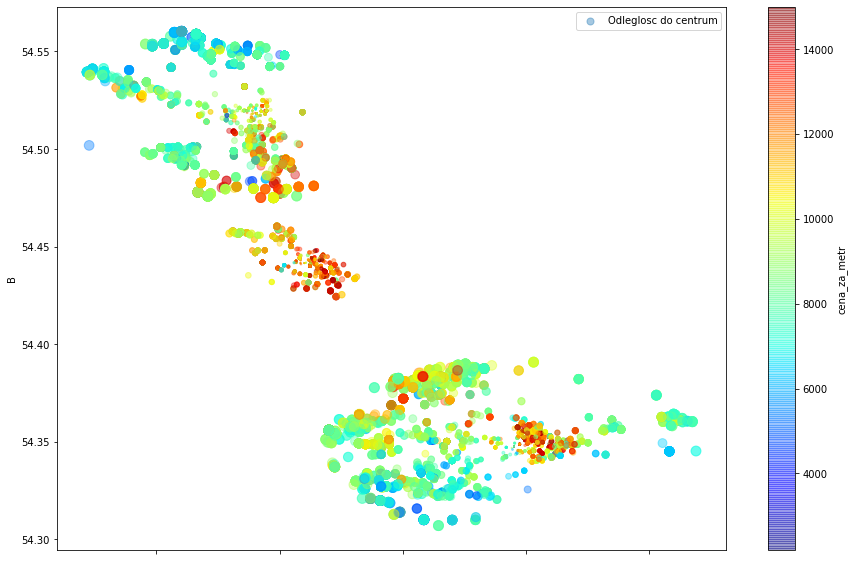

In [201]:
df2.plot(kind='scatter', x='L', y='B', alpha=0.4, c='cena_za_metr', figsize=(15,10), cmap=plt.get_cmap('jet'), s=df2['doCentrum']*20, label = 'Odleglosc do centrum')